# Training the SPOCK model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import hyperopt
import sys
sys.path.append('../spock/')
try:
    plt.style.use('paper')
except:
    pass
%matplotlib inline

Start by loading the training data generated with genNewTrainData.ipynb

In [2]:
#load datapath for clean training data that is generated
datapath = '../../cleanData/csvs/resonant/'
#thetaSTDtest
#ZcritTest
#tryMean
# dataset = pd.read_csv(datapath+'chiSecTest.csv')
dataset = pd.read_csv(datapath+'tryMean.csv')

#thetaSTDtest
# comp = pd.read_csv(datapath+'thetaSTDtest.csv')
# #remove junk columns
# comp = comp.drop(columns=['Unnamed: 0','Unnamed: 0.1'])
dataset = dataset.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

In [3]:
dataset.columns

Index(['EMcrossnear', 'EMfracstdnear', 'EPstdnear', 'MMRstrengthnear',
       'EMcrossfar', 'EMfracstdfar', 'EPstdfar', 'MMRstrengthfar', 'MEGNO',
       'MEGNOstd', 'ThetaSTD12', 'ThetaSTD23', 'chiSec', 'Zval12', 'Zcrit12',
       'Zval23', 'Zcrit23', 'threeBRfillfac', 'threeBRfillstd', 'Tsec',
       'InitialStable', 'runstring', 'instability_time',
       'shadow_instability_time', 'Stable'],
      dtype='object')

In [4]:
dataset

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,...,Zval23,Zcrit23,threeBRfillfac,threeBRfillstd,Tsec,InitialStable,runstring,instability_time,shadow_instability_time,Stable
0,0.060234,0.029458,0.001995,0.493311,0.504063,0.002902,0.000816,NaN,1.998619,0.003190,...,0.021910,NaN,0.061257,2.079027,28431.468891,True,0000000.bin,1.545872e+06,3.063700e+06,False
1,0.080547,0.016559,0.000112,0.452015,0.240504,0.006736,0.001621,0.008674,2.001688,0.004966,...,0.059626,NaN,0.032420,1.083964,3904.312508,True,0000001.bin,9.990000e+08,9.990000e+08,True
2,0.129660,0.028840,0.003182,1.000007,1.001981,0.001402,0.003742,0.010417,1.995051,0.003312,...,0.039169,NaN,0.002872,0.546301,70073.708587,True,0000002.bin,9.990000e+08,9.990000e+08,True
3,0.406112,0.036450,0.002390,0.316676,0.427768,0.036189,0.008580,0.012898,2.002498,0.000335,...,0.043470,NaN,0.000076,0.135607,18314.546267,True,0000003.bin,2.287671e+06,8.392234e+06,False
4,0.059897,0.028003,0.001623,0.334384,0.257596,0.053194,0.001287,0.034789,2.029737,0.013224,...,0.041247,NaN,0.023065,2.465622,4110.218384,True,0000004.bin,9.668931e+05,3.380350e+05,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102492,0.089252,NaN,NaN,NaN,0.310694,NaN,NaN,NaN,NaN,NaN,...,0.037360,NaN,NaN,NaN,23579.726004,False,9044761.bin,6.303165e+04,6.470086e+04,False
102493,0.082222,0.039520,0.006137,0.680177,0.664222,0.030981,0.001015,NaN,1.999417,0.004993,...,0.021827,NaN,0.049348,3.816973,4127.660202,True,9045377.bin,6.990387e+05,8.267916e+05,False
102494,0.131799,0.022001,0.000148,0.875319,0.366664,0.060675,0.016560,0.005155,2.079854,0.076477,...,0.059258,NaN,0.002791,0.564507,1130.408347,True,9045380.bin,1.193822e+07,3.363291e+07,False
102495,0.209454,0.036894,0.005252,1.492760,0.395073,0.102268,0.022792,0.029797,1.875272,0.066749,...,0.039101,NaN,0.000576,0.122898,4234.380683,True,9045382.bin,2.064407e+08,4.316851e+07,False


We can then split the data into training and testing sets, note, we will remove systems that go unstable in 1e4 orbits from the testing set

In [5]:
def train_test(dataset,features):
    '''divides the dataset into 80% training and 20% testing and returns training/testing sets'''
    Nrows = int(0.8*dataset.shape[0])
    train = dataset.iloc[:Nrows, :]
    test = dataset.iloc[Nrows:, :]
    #remove testing systems that go unstable in 1e4 orbits

    test = test.drop(test[test['InitialStable']==False].index)
    return train[features], train['Stable'], test[features], test['Stable']

In [6]:
dataset['ThetaSTD']= (dataset['ThetaSTD12']+dataset['ThetaSTD23'])/2

In [7]:
dataset

,EMcrossnear,EMfracstdnear,EPstdnear,MMRstrengthnear,EMcrossfar,EMfracstdfar,EPstdfar,MMRstrengthfar,MEGNO,MEGNOstd,...,Zcrit23,threeBRfillfac,threeBRfillstd,Tsec,InitialStable,runstring,instability_time,shadow_instability_time,Stable,ThetaSTD
0,0.060234,0.029458,0.001995,0.493311,0.504063,0.002902,0.000816,NaN,1.998619,0.003190,...,NaN,0.061257,2.079027,28431.468891,True,0000000.bin,1.545872e+06,3.063700e+06,False,0.995420
1,0.080547,0.016559,0.000112,0.452015,0.240504,0.006736,0.001621,0.008674,2.001688,0.004966,...,NaN,0.032420,1.083964,3904.312508,True,0000001.bin,9.990000e+08,9.990000e+08,True,1.139192
2,0.129660,0.028840,0.003182,1.000007,1.001981,0.001402,0.003742,0.010417,1.995051,0.003312,...,NaN,0.002872,0.546301,70073.708587,True,0000002.bin,9.990000e+08,9.990000e+08,True,0.961767
3,0.406112,0.036450,0.002390,0.316676,0.427768,0.036189,0.008580,0.012898,2.002498,0.000335,...,NaN,0.000076,0.135607,18314.546267,True,0000003.bin,2.287671e+06,8.392234e+06,False,1.726555
4,0.059897,0.028003,0.001623,0.334384,0.257596,0.053194,0.001287,0.034789,2.029737,0.013224,...,NaN,0.023065,2.465622,4110.218384,True,0000004.bin,9.668931e+05,3.380350e+05,False,0.975575
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102492,0.089252,NaN,NaN,NaN,0.310694,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,23579.726004,False,9044761.bin,6.303165e+04,6.470086e+04,False,1.718816
102493,0.082222,0.039520,0.006137,0.680177,0.664222,0.030981,0.001015,NaN,1.999417,0.004993,...,NaN,0.049348,3.816973,4127.660202,True,9045377.bin,6.990387e+05,8.267916e+05,False,0.943830
102494,0.131799,0.022001,0.000148,0.875319,0.366664,0.060675,0.016560,0.005155,2.079854,0.076477,...,NaN,0.002791,0.564507,1130.408347,True,9045380.bin,1.193822e+07,3.363291e+07,False,1.010589
102495,0.209454,0.036894,0.005252,1.492760,0.395073,0.102268,0.022792,0.029797,1.875272,0.066749,...,NaN,0.000576,0.122898,4234.380683,True,9045382.bin,2.064407e+08,4.316851e+07,False,1.135955


In [8]:
near = ['EMcrossnear', 'EMfracstdnear', 'EPstdnear','MMRstrengthnear'] #''
far = ['EMcrossfar', 'EMfracstdfar', 'EPstdfar','MMRstrengthfar']#  'MMRstrengthfar'
megno = ['MEGNO', 'MEGNOstd']

features = near + far  + megno + ['Tsec', 'ThetaSTD', 'chiSec','Zval12','Zcrit12','Zval23','Zcrit23', 'threeBRfillstd', 'threeBRfillfac']

featList = []
featList.append(['MEGNO','MEGNOstd'])
featList.append(['ThetaSTD'])
featList.append(['Tsec'])
featList.append(['chiSec'])
featList.append(['Zval12','Zval23'])
featList.append(['Zcrit12','Zcrit23'])
featList.append(['threeBRfillstd', 'threeBRfillfac'])
featList.append(['MMRstrengthnear','MMRstrengthfar'])
featList.append(['EPstdnear','EPstdfar'])
featList.append(['EMcrossnear', 'EMfracstdnear','EMcrossfar', 'EMfracstdfar'])
trainX, trainY, testX, testY = train_test(dataset, features)

dtrain = xgb.DMatrix(trainX, trainY)
dtest = xgb.DMatrix(testX, testY)

# Tuning hyperparameter
We can determine the idea values for the different hyperparameters.

We will start by creating and testing a collection of models that have randomly selected hyperparameters

scale_pos_weight is a hyperparameter used to account for skewed training data, it does this by weighting false positives and negatives differently. A typical value can be obtained by dividing your negative outcomes in your training data by your positive outcomes.

In [9]:
trainingBalance = trainY.value_counts()[False]/trainY.value_counts()[True]

We can then establish the different parameter space that we will be testing different hyperparameter values within.

# SPOCK

We can now train the final spock model

In [10]:
from sklearn import metrics
from sklearn.metrics import roc_curve, confusion_matrix, auc
def ROC_curve( model, x,y):
    preds = model.predict_proba(x)[:,1]
    fpr, tpr, ROCthresholds = roc_curve(y, preds)
    roc_auc = metrics.roc_auc_score(y, preds)
    return roc_auc, fpr, tpr, ROCthresholds

In [11]:
model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)


In [ ]:
results = {}
for i, each, in enumerate(featList):
    print(i)
    testFeat = featList[:i] + featList[i+1:]
    passFeat = sum(testFeat, start=[])
    print(passFeat)
    model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)
    model.fit(trainX[passFeat],trainY)
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX[passFeat], testY)
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    fpr = fpr[tprthreshindex]
    results[str(each)] = [roc_auc, fpr]
ablTest = pd.DataFrame.from_dict(results, orient = 'index',columns=['AUC','FPR'])
ablTest.sort_values('AUC')


0
['ThetaSTD', 'Tsec', 'chiSec', 'Zval12', 'Zval23', 'Zcrit12', 'Zcrit23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
1
['MEGNO', 'MEGNOstd', 'Tsec', 'chiSec', 'Zval12', 'Zval23', 'Zcrit12', 'Zcrit23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
2
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'chiSec', 'Zval12', 'Zval23', 'Zcrit12', 'Zcrit23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
3
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'Zcrit12', 'Zcrit23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
4
['MEGNO', 'MEGNOstd', 'Th

In [14]:
ablTest = pd.DataFrame.from_dict(results, orient = 'index',columns=['AUC','FPR'])

In [22]:
ablTest.sort_values('AUC')

,AUC,FPR
"['EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']",0.944495,0.159886
"['MEGNO', 'MEGNOstd']",0.954835,0.133111
"['Zval12', 'Zval23']",0.956850,0.128868
"['MMRstrengthnear', 'MMRstrengthfar']",0.959044,0.121636
['ThetaSTD'],0.959452,0.117533
"['threeBRfillstd', 'threeBRfillfac']",0.959502,0.122957
"['EPstdnear', 'EPstdfar']",0.959503,0.119063
['chiSec'],0.959897,0.116698
['Tsec'],0.960627,0.114612
"['Zcrit12', 'Zcrit23']",0.960904,0.116003


In [11]:
featList.remove(['Zcrit12', 'Zcrit23'])

In [25]:
results = {}
for i, each, in enumerate(featList):
    print(i)
    testFeat = featList[:i] + featList[i+1:]
    passFeat = sum(testFeat, start=[])
    print(passFeat)
    model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)
    model.fit(trainX[passFeat],trainY)
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX[passFeat], testY)
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    fpr = fpr[tprthreshindex]
    results[str(each)] = [roc_auc, fpr]
ablTest = pd.DataFrame.from_dict(results, orient = 'index',columns=['AUC','FPR'])
ablTest.sort_values('AUC')

0
['ThetaSTD', 'Tsec', 'chiSec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
1
['MEGNO', 'MEGNOstd', 'Tsec', 'chiSec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
2
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'chiSec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
3
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']
4
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'Tsec', 'chiSec', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRst

,AUC,FPR
"['EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']",0.944495,0.159886
"['MEGNO', 'MEGNOstd']",0.954835,0.133111
"['Zval12', 'Zval23']",0.956850,0.128868
"['MMRstrengthnear', 'MMRstrengthfar']",0.959044,0.121636
['ThetaSTD'],0.959452,0.117533
"['threeBRfillstd', 'threeBRfillfac']",0.959502,0.122957
"['EPstdnear', 'EPstdfar']",0.959503,0.119063
['chiSec'],0.959897,0.116698
['Tsec'],0.960627,0.114612


In [12]:
featList.remove(['chiSec'])

In [13]:
results = {}
for i, each, in enumerate(featList):
    print(i)
    testFeat = featList[:i] + featList[i+1:]
    passFeat = sum(testFeat, start=[])
    print(passFeat)
    model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)
    model.fit(trainX[passFeat],trainY)
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX[passFeat], testY)
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    fpr = fpr[tprthreshindex]
    results[str(each)] = [roc_auc, fpr]
ablTest = pd.DataFrame.from_dict(results, orient = 'index',columns=['AUC','FPR'])
ablTest.sort_values('AUC')

0
['ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar']


KeyboardInterrupt: 

In [14]:
featList.remove(['EMcrossnear', 'EMfracstdnear', 'EMcrossfar', 'EMfracstdfar'])

In [15]:
featList.append(['EMcrossnear','EMcrossfar'])
featList.append(['EMfracstdnear','EMfracstdfar'])

In [25]:
featList = f

In [26]:
featList

['MEGNO',
 'MEGNOstd',
 'ThetaSTD',
 'Tsec',
 'Zval12',
 'Zval23',
 'threeBRfillstd',
 'threeBRfillfac',
 'MMRstrengthnear',
 'MMRstrengthfar',
 'EPstdnear',
 'EPstdfar',
 'EMcrossnear',
 'EMcrossfar',
 'EMfracstdnear',
 'EMfracstdfar']

In [28]:
results = {}
for i, each, in enumerate(featList):
    print(i)
    testFeat = featList[:i] + featList[i+1:]
    #passFeat = sum(testFeat, start=[])
    print(testFeat)
    model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)
    model.fit(trainX[testFeat],trainY)
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX[testFeat], testY)
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    fpr = fpr[tprthreshindex]
    results[str(each)] = [roc_auc, fpr]
ablTest = pd.DataFrame.from_dict(results, orient = 'index',columns=['AUC','FPR'])
ablTest.sort_values('AUC')

0
['MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
1
['MEGNO', 'ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
2
['MEGNO', 'MEGNOstd', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
3
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'Zval12', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
4
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval23', 'threeBRfillstd', 'threeBRfillfac', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPst

,AUC,FPR
EMfracstdnear,0.953803,0.136379
Zval23,0.957115,0.124626
EMcrossfar,0.957196,0.125739
Tsec,0.957232,0.125808
EPstdnear,0.958279,0.120036
MMRstrengthnear,0.958427,0.123722
EPstdfar,0.958489,0.123513
EMcrossnear,0.958498,0.121914
ThetaSTD,0.958537,0.125322
EMfracstdfar,0.958592,0.122053


In [29]:
featList.remove('threeBRfillfac')

In [30]:
results = {}
for i, each, in enumerate(featList):
    print(i)
    testFeat = featList[:i] + featList[i+1:]
    #passFeat = sum(testFeat, start=[])
    print(testFeat)
    model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)
    model.fit(trainX[testFeat],trainY)
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX[testFeat], testY)
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    fpr = fpr[tprthreshindex]
    results[str(each)] = [roc_auc, fpr]
ablTest = pd.DataFrame.from_dict(results, orient = 'index',columns=['AUC','FPR'])
ablTest.sort_values('AUC')

0
['MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
1
['MEGNO', 'ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
2
['MEGNO', 'MEGNOstd', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
3
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'Zval12', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
4
['MEGNO', 'MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
5
['MEGNO', 'MEGNOstd

,AUC,FPR
EMfracstdnear,0.953061,0.143960
Zval23,0.956700,0.127547
EMcrossfar,0.956777,0.126713
Tsec,0.956943,0.128382
EMcrossnear,0.957674,0.125043
EMfracstdfar,0.957772,0.128243
ThetaSTD,0.957991,0.127964
EPstdnear,0.958458,0.123374
EPstdfar,0.958517,0.122053
Zval12,0.958545,0.124070


In [31]:
featList.remove('MEGNO')

In [32]:
results = {}
for i, each, in enumerate(featList):
    print(i)
    testFeat = featList[:i] + featList[i+1:]
    #passFeat = sum(testFeat, start=[])
    print(testFeat)
    model = XGBClassifier(learning_rate = 0.06, 
                         max_depth = 15, 
                         subsample = 0.95,
                         min_child_weight = 15,
                         n_estimators = 200,
                         scale_pos_weight=trainingBalance)
    model.fit(trainX[testFeat],trainY)
    roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX[testFeat], testY)
    tprthreshindex = np.where(tpr >=0.9)[0][0]
    fpr = fpr[tprthreshindex]
    results[str(each)] = [roc_auc, fpr]
ablTest = pd.DataFrame.from_dict(results, orient = 'index',columns=['AUC','FPR'])
ablTest.sort_values('AUC')

0
['ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
1
['MEGNOstd', 'Tsec', 'Zval12', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
2
['MEGNOstd', 'ThetaSTD', 'Zval12', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
3
['MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval23', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
4
['MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval12', 'threeBRfillstd', 'MMRstrengthnear', 'MMRstrengthfar', 'EPstdnear', 'EPstdfar', 'EMcrossnear', 'EMcrossfar', 'EMfracstdnear', 'EMfracstdfar']
5
['MEGNOstd', 'ThetaSTD', 'Tsec', 'Zval12', 'Zval23', 'MMRstrength

,AUC,FPR
MEGNOstd,0.952656,0.140830
EMfracstdnear,0.952708,0.145490
Zval23,0.956075,0.131372
EMcrossfar,0.956144,0.132763
Tsec,0.956736,0.129077
EMfracstdfar,0.957325,0.127686
EMcrossnear,0.957582,0.125461
ThetaSTD,0.957651,0.125739
Zval12,0.957823,0.126434
threeBRfillstd,0.958051,0.129773


In [19]:
f = sum(featList, start=[])

In [24]:
f

['MEGNO',
 'MEGNOstd',
 'ThetaSTD',
 'Tsec',
 'Zval12',
 'Zval23',
 'threeBRfillstd',
 'threeBRfillfac',
 'MMRstrengthnear',
 'MMRstrengthfar',
 'EPstdnear',
 'EPstdfar',
 'EMcrossnear',
 'EMcrossfar',
 'EMfracstdnear',
 'EMfracstdfar']

In [20]:
model.fit(trainX[f],trainY)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.06, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=15, max_leaves=None,
              min_child_weight=15, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Text(0.5, 1.0, 'ROC curve (AUC = 0.960)')

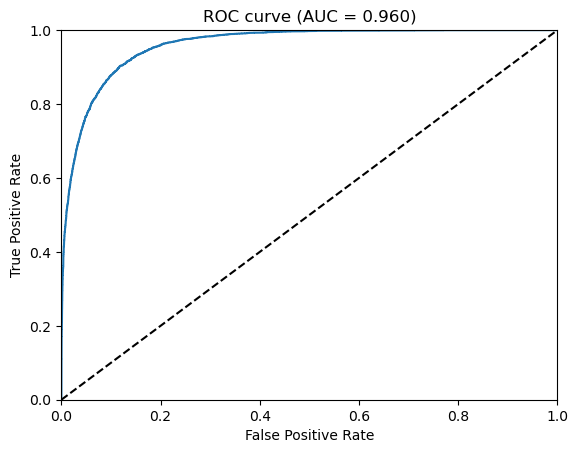

In [21]:
roc_auc, fpr, tpr, ROCthresholds = ROC_curve(model, testX[f], testY)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC curve (AUC = {0:.3f})'.format(roc_auc))

In [22]:
#check exact number
roc_auc

0.9598973994790049

We can check FPR when we have a TPR of .9

In [19]:
tprthreshindex = np.where(tpr >=0.9)[0][0]
fpr[tprthreshindex]

0.11711523749913068

We can check feature importance

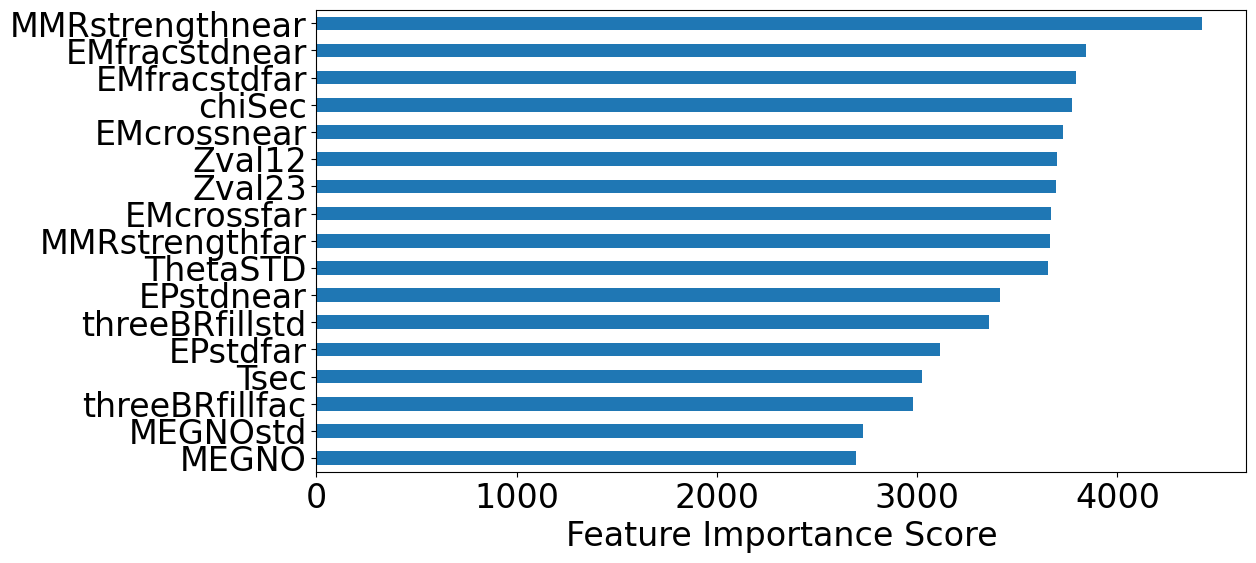

In [20]:
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
ax = feat_imp.plot.barh(figsize=(12,6), fontsize=24)
ax.set_xlabel('Feature Importance Score', fontsize=24)
ax.invert_yaxis()

and save the model

In [21]:
#model.save_model('../spock/models/spock.json')